***
# Logistic Regression and Support Vector Machines
MSDS 7331-407, Lab 2  
*Jenna Ford, Edward Fry, Christian Nava, and Jonathan Tan* 
***

## Table of Contents

<a href='#Section_1'> 1. Preparation and Dataset Loading </a>  
<a href='#Section_2'> 2. Data Cleansing (Lab 1) </a>  
<a href='#Section_3'> 3. Create A Logistic Regression Model and a Support Vector Machine Model </a>  
<a href='#Section_4'> 4. Model Advantages </a>  
<a href='#Section_5'> 5. Weight Interpretation from Logistic Regression Model</a>  
<a href='#Section_6'> 6. Insights from Support Vectors </a>  

<!-- <a href='#Section_4_a'> &nbsp;&nbsp;&nbsp; a. Missing Values </a>  --> 
<!-- <a href='#Section_4_c_i'> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; i. Cross Street </a>    --> 

<a id = 'Section_1'></a>

## 1. Preparation and Dataset Loading

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Creating training and test sets
import sklearn

# File system management
import os.path

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#training/test split
from sklearn.model_selection import ShuffleSplit

# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# here we can change some of the parameters interactively
from ipywidgets import widgets as wd
from sklearn.model_selection import cross_val_score

#for weights standardization
from sklearn.preprocessing import StandardScaler

# Support vector machines
from sklearn.svm import SVC

In [2]:
# Constants
DATAPATH_BASE = 'https://machinelearningi.blob.core.windows.net/group-project/'
DATAPATH_SAS_TOKEN = '?sv=2019-02-02&ss=bfqt&srt=sco&sp=rwdlacup&se=2020-04-27T11:12:37Z&st=2020-01-23T04:12:37Z&spr=https&sig=jpIpjrp8dIg9eyUyPpmgTe5yj9i1ZoCSru5kBVHcUO8%3D'
DATAPATH_FILENAME = 'Arrest_Data_from_2010_to_Present.csv'
DATAPATH_SMALL_FILENAME = 'Arrest_Data_from_2010_to_Present_Small.csv'

# Fully qualified paths ready to use
DATA_SOURCE = "".join([DATAPATH_BASE, DATAPATH_SMALL_FILENAME, DATAPATH_SAS_TOKEN])

# Options
pd.set_option('float_format', '{:.2f}'.format)  # Reign in the scientific notation for reasonable values

# Load data for analysis; only read if needed because the import can take a long time
try:
    if len(df.index) < 1:
        df_raw = pd.read_csv(DATA_SOURCE) # If we get here, the dataframe was empty
except:   
    df_raw = pd.read_csv(DATA_SOURCE) # If we get here, the dataframe did not exist
    

In [3]:
df = df_raw
print("The dataset has {:,} rows and {:,} columns".format(*df.shape))

The dataset has 13,266 rows and 17 columns


<a id = 'Section_2'></a>

## 2. Data Cleansing (Lab 1)

The data cleansing steps performed below are repeated from Lab 1.

In [4]:
# Time - filter out 0 and missing
df = df[df['Time'] != 0]
df['Time'] = df['Time'].astype(str) 
df = df[df['Time'] != 'nan']

# Time - Convert float to string. Get rid of decimals. Replace missing or invalid values with '0000'.
df['Time'] = df['Time'].astype(str).str.split(".", expand = True)[0].replace(to_replace = ['2400','nan'], value = '0000') 

# Time - Fill time column with leading zeros to have 4 characters total
df['Time'] = df['Time'].apply(lambda x: '{0:0>4}'.format(x))

# Time - Add colon to Time values by converting attribute to a datetime variable 
df['Time'] = pd.to_datetime(df['Time'], format = '%H%M').dt.time

# Age - Drop the observations where Age is less than 16
df.drop(df[df['Age'] < 16].index, inplace = True) 

# Arrest Type Code - Drop the observations where Arrest Type Code = 'D'
df.drop(df[df['Arrest Type Code'] == 'D'].index, inplace = True) 

# Descent Code - Re-classify any descent not in (B,H,O,W) into 0
descent_list = ['B','H','O','W']
df['Descent Code'] = np.where(np.isin(df['Descent Code'],descent_list),df['Descent Code'],'O')

# Get hour
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour

# Convert Arrest Date to datetime
df['Arrest Date'] = pd.to_datetime(df['Arrest Date'])

# Extract year, month, and day of week and add to dataframe as new attributes
df['arrest_year']= df['Arrest Date'].dt.year
df['arrest_month']= df['Arrest Date'].dt.month
df['arrest_day_of_week'] = df['Arrest Date'].dt.weekday_name

# remove unecessary columns
df.drop(['Cross Street','Charge Description','Charge','Charge Group Description','Time',
         'Arrest Date','Report ID','Address','Area Name'], axis=1, inplace=True)

# Change data types
df['Age'] = df['Age'].astype(np.int8)
df['Reporting District'] = df['Reporting District'].astype(np.str)
df['Area ID'] = df['Area ID'].astype(np.str)
df['Charge Group Code'] = df['Charge Group Code'].astype(np.str)
df['Hour'] = df['Hour'].astype(np.str)
df['arrest_year'] = df['arrest_year'].astype(np.str)
df['arrest_month'] = df['arrest_month'].astype(np.str)
df['arrest_day_of_week'] = df['arrest_day_of_week'].astype(np.str)

# print clean dataset
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12766 entries, 0 to 13265
Data columns (total 12 columns):
Area ID               12766 non-null object
Reporting District    12766 non-null object
Age                   12766 non-null int8
Sex Code              12766 non-null object
Descent Code          12766 non-null object
Charge Group Code     12766 non-null object
Arrest Type Code      12766 non-null object
Location              12766 non-null object
Hour                  12766 non-null object
arrest_year           12766 non-null object
arrest_month          12766 non-null object
arrest_day_of_week    12766 non-null object
dtypes: int8(1), object(11)
memory usage: 1.2+ MB


In [5]:
print("The clean data set has {:,} rows and {:,} columns".format(*df.shape))

The clean data set has 12,766 rows and 12 columns


<a id = 'Section_3'></a>

## 3. Create A Logistic Regression Model and a Support Vector Machine Model

In order to perform a logistic regression, all categorical variables need to be dummy encoded. For example, if a variable has 3 different categories we need to split this out to 3 different variables. The code below does this for the categorical variables used in the model. The target variable `Arrest Type Code` is transformed to range from 0-3 instead of alphabetical letters representing the arrest type. Also, `Age` was bucketed into 10 year increments.

In [6]:
# Encode Arrest Type Code as Categorical
cleanup_arrest = {"Arrest Type Code": {"F": 0, "M": 1, "I": 2, "O":3}}
df.replace(cleanup_arrest,inplace=True)

# Create buckets for Age
df['age_range'] = pd.cut(df.Age,[16,25,35,45,55,65,75,1e6],4,labels=[0,1,2,3,4,5,6]) # this creates a new variable
df['age_range'] = df.age_range.astype(np.int)

# Perform one-hot encoding of the categorical data "Descent Code"
tmp_df = pd.get_dummies(df['Descent Code'],prefix='Descent')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Replace the current Sex atribute with something slightly more intuitive and readable
df['IsMale'] = df['Sex Code']=='M' 
df.IsMale = df.IsMale.astype(np.int)

# Perform one-hot encoding of the categorical data "DOW"
tmp_df = pd.get_dummies(df['arrest_day_of_week'],prefix='DOW')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Area ID"
tmp_df = pd.get_dummies(df['Area ID'],prefix='Area')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Charge Group Code"
tmp_df = pd.get_dummies(df['Charge Group Code'],prefix='Charge')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Hour"
tmp_df = pd.get_dummies(df['Hour'],prefix='Hour')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Month"
tmp_df = pd.get_dummies(df['arrest_month'],prefix='Month')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

After properly encoding all variables, we remove the original variables from the dataset. We also remove any variables that will not be used in this model. Information about the resulting dataframe is printed for verification and the first 5 records are printed out.

Note that this is just a first pass at the model, other variables will be used in future iterations.

In [7]:
df_logreg = df

df.drop(['Sex Code','Descent Code','arrest_day_of_week','Area ID','Reporting District','Charge Group Code',
         'Location','arrest_year','Age','Hour','arrest_month'], axis=1, inplace=True)
    
df_logreg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12766 entries, 0 to 13265
Data columns (total 99 columns):
Arrest Type Code    12766 non-null int64
age_range           12766 non-null int32
Descent_B           12766 non-null uint8
Descent_H           12766 non-null uint8
Descent_O           12766 non-null uint8
Descent_W           12766 non-null uint8
IsMale              12766 non-null int32
DOW_Friday          12766 non-null uint8
DOW_Monday          12766 non-null uint8
DOW_Saturday        12766 non-null uint8
DOW_Sunday          12766 non-null uint8
DOW_Thursday        12766 non-null uint8
DOW_Tuesday         12766 non-null uint8
DOW_Wednesday       12766 non-null uint8
Area_1              12766 non-null uint8
Area_10             12766 non-null uint8
Area_11             12766 non-null uint8
Area_12             12766 non-null uint8
Area_13             12766 non-null uint8
Area_14             12766 non-null uint8
Area_15             12766 non-null uint8
Area_16             12766 non-

In [8]:
df.head()

,Arrest Type Code,age_range,Descent_B,Descent_H,Descent_O,Descent_W,IsMale,DOW_Friday,DOW_Monday,DOW_Saturday,...,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9
0,1,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,2,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,3,0,1,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,1,0,1,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0


The section of code below sets up the frame for the logistic regression model. The target `Arrest Type Code` is identified and all other variables are assigned as explanatory variables.

Also indicated in this section of code is the training/test split of 80%/20%. The model will be built with 80% of the data and tested on the remaining 20%.

Note that only one iteration of the model is being run. This is due to the time is takes to run the model with the number of observations and variables we have in the dataset. In future assignments, we will run through more iterations.

In [9]:
# we want to predict the X and y data as follows:
if 'Arrest Type Code' in df_logreg:
    y = df_logreg['Arrest Type Code'].values # get the labels we want
    del df_logreg['Arrest Type Code'] # get rid of the class label
    X = df_logreg.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 1
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None)


The code below splits the data into the training/test split identified earlier and runs a multi-nomial logistic regression.

In [10]:
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(multi_class='multinomial', solver='newton-cg' ) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.774079874706343
confusion matrix
 [[ 534  280    0    0]
 [ 128 1443    0    0]
 [   1  108    0    0]
 [   0   60    0    0]]


The accuracy for this iteration of the model is 75.9%. Without adjusting model parameters, we are already very close to our target accuracy of 75%. The various iterations we have run ranged from accuracy of 70% to 78%.

It is interesting to note that the model never predicts the arrest type codes I-Infraction and O-Other. In future iterations, we will try to improve this, but it may be difficult due to the limited number of observations available for the arrest types.

In [11]:
def lr_explor(cost):
    lr_clf = LogisticRegression(multi_class='multinomial', C=cost, class_weight=None,solver='newton-cg') # get object
    accuracies = cross_val_score(lr_clf,X,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05),__manual=True)

interactive(children=(FloatSlider(value=2.451, description='cost', max=5.0, min=0.001, step=0.05), Output()), …

<function __main__.lr_explor(cost)>

In [12]:
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(multi_class='multinomial', solver='newton-cg' ) # get object, the 'C' value is less
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

accuracy: 0.7889584964761159
[[ 550  237    0    2]
 [ 148 1424   21    5]
 [   2   74   37    0]
 [   0   50    0    4]]


In [13]:
# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df_logreg.columns) # combine attributes
zipped = list(zip_vars) 
zipped = sorted(zipped, key = lambda x: x[0][0])
for coef, name in zipped:
    print(name, 'has weight of', coef[0]) # now print them out

Charge_18.0 has weight of -1.2919136209521818
Charge_17.0 has weight of -0.9373078887231768
Charge_nan has weight of -0.6117904331997424
Charge_20.0 has weight of -0.4930547017925723
Charge_24.0 has weight of -0.2628205473580497
Charge_19.0 has weight of -0.24777768088611157
Charge_15.0 has weight of -0.21941195901060917
Area_14 has weight of -0.19757364737403746
Charge_27.0 has weight of -0.17053292912506296
Charge_23.0 has weight of -0.1450544727601103
Area_6 has weight of -0.14143479736084702
Charge_21.0 has weight of -0.13516336684340263
Charge_13.0 has weight of -0.12934009419086553
Area_2 has weight of -0.09831374278269793
DOW_Wednesday has weight of -0.08407576343859911
Area_3 has weight of -0.0792697913879802
Area_8 has weight of -0.06721753342308537
Hour_7 has weight of -0.06622007637978003
Month_8 has weight of -0.06506557149534296
Area_15 has weight of -0.06189485310297572
Hour_14 has weight of -0.05940333218816
Hour_8 has weight of -0.058048740103588764
Area_19 has weight o

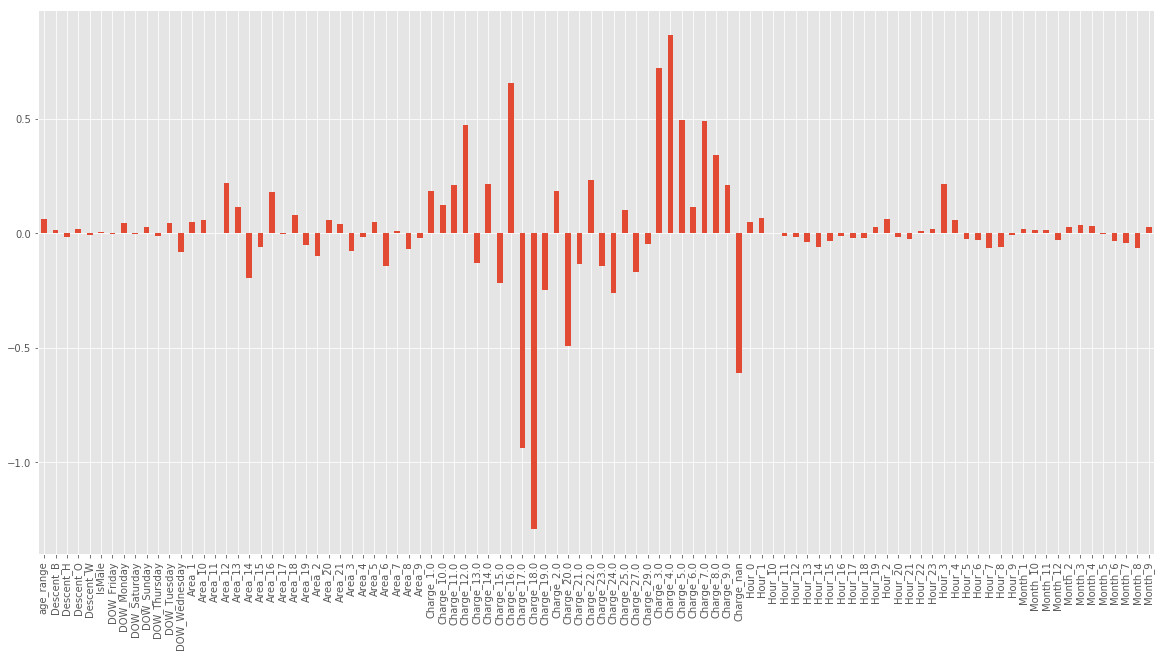

In [14]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(20,10))


weights = pd.Series(lr_clf.coef_[0],index=df_logreg.columns)
weights.plot(kind='bar')
plt.show()

In [15]:
#want to filter out smaller weights to see larger impacts

## 4. Support Vector Machine

In [45]:
# lets investigate SVMs on the data and play with the parameters and kernels

# train the model with a linear kernal
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('Linear SVM Accuracy:', acc )
print(conf)

# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

Linear SVM Accuracy: 0.7963978073610023
[[ 566  223    0    0]
 [ 149 1426   23    0]
 [   2   69   42    0]
 [   0   54    0    0]]
(6545, 98)
(6545,)
[2329 3580  426  210]


[[ 1.53387354e-06 -9.72033192e-07 -1.85170726e-06  9.01577043e-06
  -1.96233773e-06 -7.00512913e-07 -3.62603247e-06  3.49320948e-06
  -3.87397372e-06 -9.19312001e-07  7.14763190e-06  8.76661139e-06
  -1.02066679e-05 -9.24814647e-06  9.39707805e-06  6.35109718e-06
   2.20024447e-06 -6.66827042e-06 -6.61906974e-06  1.47829273e-06
   3.92885660e-06  1.07417840e-05  1.15307629e-05 -1.07832377e-05
  -2.50820101e-06  1.57591167e-06 -4.32190288e-06 -6.23015507e-06
   1.35618967e-05  2.53052604e-06 -7.02585315e-06  6.58999423e-06
  -7.91020003e-06  8.70876094e-06  7.08251541e-02  1.17578811e-01
   9.71197563e-02  2.06719378e-01 -1.08066648e-01 -6.16422611e-02
  -4.58398294e-02  4.69147292e-01 -1.14184033e-01 -1.67919380e-01
  -3.16549181e-02  6.94706030e-02 -1.03200452e-01 -2.88037371e-02
  -1.73826783e-01 -1.25247961e-01 -2.31219164e-01  2.40816779e-02
  -3.66656489e-02 -1.01845436e-02  1.90407110e-01  3.45035780e-01
   1.92802889e-01 -1.30739979e-01  1.93297222e-01 -1.29198355e-01
   9.61170

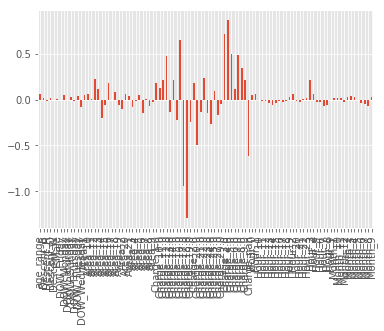

In [51]:
# Look at the weights for linear SVM
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=df.columns)
weights.plot(kind='bar')

In [43]:
# train the model just as before with an rbf kernal
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('SVM Accuracy:', acc )
print(conf)

# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

SVM Accuracy: 0.7975724353954581
[[ 565  224    0    0]
 [ 149 1444    5    0]
 [   2   83   28    0]
 [   0   54    0    0]]
(6500, 98)
(6500,)
[2387 3473  430  210]


In [19]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = df.iloc[train_indices].copy() # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['Arrest Type Code'] = y[svm_clf.support_] # add back in the 'Arrest Type Code' Column to the pandas dataframe
df['Arrest Type Code'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 10451 to 12148
Data columns (total 99 columns):
age_range           6500 non-null int32
Descent_B           6500 non-null uint8
Descent_H           6500 non-null uint8
Descent_O           6500 non-null uint8
Descent_W           6500 non-null uint8
IsMale              6500 non-null int32
DOW_Friday          6500 non-null uint8
DOW_Monday          6500 non-null uint8
DOW_Saturday        6500 non-null uint8
DOW_Sunday          6500 non-null uint8
DOW_Thursday        6500 non-null uint8
DOW_Tuesday         6500 non-null uint8
DOW_Wednesday       6500 non-null uint8
Area_1              6500 non-null uint8
Area_10             6500 non-null uint8
Area_11             6500 non-null uint8
Area_12             6500 non-null uint8
Area_13             6500 non-null uint8
Area_14             6500 non-null uint8
Area_15             6500 non-null uint8
Area_16             6500 non-null uint8
Area_17             6500 non-null uint8
Area_18 

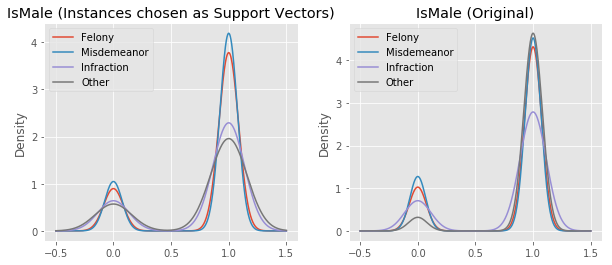

In [33]:
from pandas.plotting import boxplot

# Group the original data and the support vectors
df_grouped_support = df_support.groupby(['Arrest Type Code'])
df_grouped = df.groupby(['Arrest Type Code'])

# Plot KDE of Different variables
vars_to_plot = ['IsMale']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Felony','Misdemeanor','Infraction','Other'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Felony','Misdemeanor','Infraction','Other'])
    plt.title(v+' (Original)')

In [39]:
# Linear SVM classifier with Stochastic Descent
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()

svm_sgd.fit(scl.fit_transform(X_train_scaled),y_train)
yhat = svm_sgd.predict(scl.transform(X_test_scaled))

svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

conf = mt.confusion_matrix(y_test,yhat)
acc = mt.accuracy_score(y_test,yhat)

print('SVM w/Stochastic Descent:', acc)
print(conf)

# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

SVM w/Stochastic Descent: 0.7889584964761159
[[ 566  223    0    0]
 [ 149 1449    0    0]
 [   2  111    0    0]
 [   0   54    0    0]]
(6500, 98)
(6500,)
[2387 3473  430  210]


In [40]:
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

conf = mt.confusion_matrix(y_test,yhat)
acc = mt.accuracy_score(y_test,yhat)

print('Linear SVM w/Stochastic Descent:', acc)
print(conf)

# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

Linear SVM w/Stochastic Descent: 0.7889584964761159
[[ 566  223    0    0]
 [ 149 1449    0    0]
 [   2  111    0    0]
 [   0   54    0    0]]
(6545, 98)
(6545,)
[2329 3580  426  210]
